In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        if num_params == 4:
            h = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T = torch.tensor([-0.9802, 0.2283, 4.0217, 1.5428, 0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h = torch.tensor([1.1507, 1.9843, 4.1558, 2.2380, 1.1598, 1.1832, 0.6838, 0.9808, 0.9599, 1.5397, -2.4526, 1.5903])
            d = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T = torch.tensor([0.5358, 2.1906, 4.5437, 2.4850, 1.3502, 0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192, 0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259, 0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T = torch.tensor([1.6926, -3.4559, 5.9155, 4.1239, -2.5486, 1.9903, 0.7669, 0.1584, -0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489, 0.3304, -3.6109])

        self.h = nn.Parameter(h + torch.normal(0, 0.0001, size=h.size()))
        self.d = nn.Parameter(d + torch.normal(0, 0.0001, size=d.size()))
        self.T = nn.Parameter(T + torch.normal(0, 0.0001, size=T.size()))
    
    def add_noise(self):
        self.h.data += torch.normal(0, 0.0001, size=self.h.size(), device=self.h.device)
        self.d.data += torch.normal(0, 0.0001, size=self.d.size(), device=self.d.device)
        self.T.data += torch.normal(0, 0.0001, size=self.T.size(), device=self.T.device)

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

Epoch 1/20000, Loss: 0.12473563104867935
Epoch 1001/20000, Loss: 0.12473694980144501
Epoch 2001/20000, Loss: 0.12474426627159119
Epoch 3001/20000, Loss: 0.12475746870040894
Epoch 4001/20000, Loss: 0.07984597980976105
Epoch 5001/20000, Loss: 0.07602895051240921
Epoch 6001/20000, Loss: 0.07602309435606003
Epoch 7001/20000, Loss: 0.07602500170469284
Epoch 8001/20000, Loss: 0.07603517174720764
Epoch 9001/20000, Loss: 0.07601985335350037
Epoch 10001/20000, Loss: 0.076038658618927
Epoch 11001/20000, Loss: 0.07603174448013306
Epoch 12001/20000, Loss: 0.07601794600486755
Epoch 13001/20000, Loss: 0.0760192945599556
Epoch 14001/20000, Loss: 0.07603178918361664
Epoch 15001/20000, Loss: 0.0760212242603302
Epoch 16001/20000, Loss: 0.07602008432149887
Epoch 17001/20000, Loss: 0.07600785791873932
Epoch 18001/20000, Loss: 0.07602236419916153
Epoch 19001/20000, Loss: 0.07602681964635849
Loss values: [0.12473563104867935, 0.12474139779806137, 0.12474213540554047, 0.12475249171257019, 0.1247466430068016,

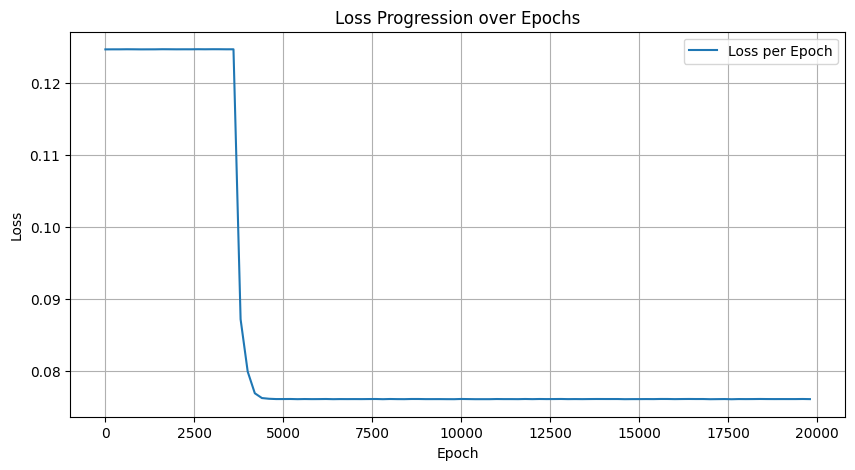

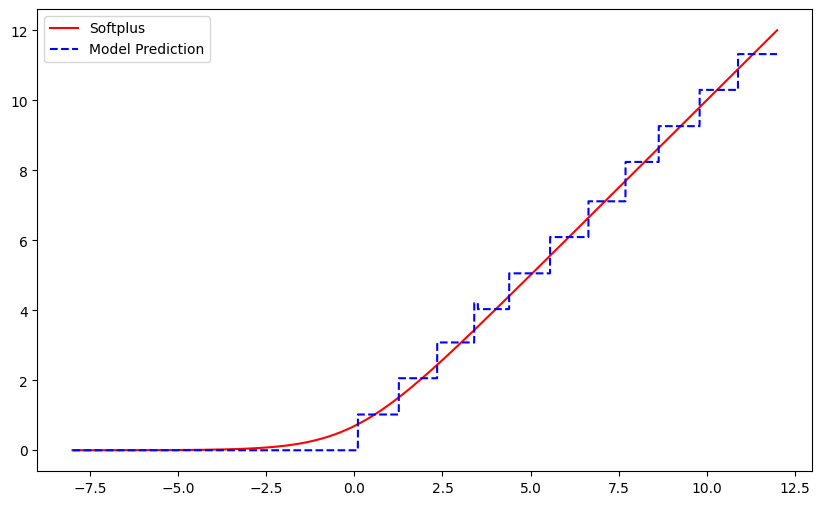

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.005816843826323748
Epoch 1001/20000, Loss: 0.005814421456307173
Epoch 2001/20000, Loss: 0.005821995437145233
Epoch 3001/20000, Loss: 0.005816049408167601
Epoch 4001/20000, Loss: 0.005817857570946217
Epoch 5001/20000, Loss: 0.005818287841975689
Epoch 6001/20000, Loss: 0.005820173770189285
Epoch 7001/20000, Loss: 0.00581761822104454
Epoch 8001/20000, Loss: 0.00582121079787612
Epoch 9001/20000, Loss: 0.0058148205280303955
Epoch 10001/20000, Loss: 0.005816332995891571
Epoch 11001/20000, Loss: 0.005820448510348797
Epoch 12001/20000, Loss: 0.005818807519972324
Epoch 13001/20000, Loss: 0.005817099008709192
Epoch 14001/20000, Loss: 0.0058167558163404465
Epoch 15001/20000, Loss: 0.005816915072500706
Epoch 16001/20000, Loss: 0.005818488541990519
Epoch 17001/20000, Loss: 0.005812021903693676
Epoch 18001/20000, Loss: 0.005820656195282936
Epoch 19001/20000, Loss: 0.005815776530653238
Loss values: [0.005816843826323748, 0.005815248936414719, 0.0058181434869766235, 0.0058207884

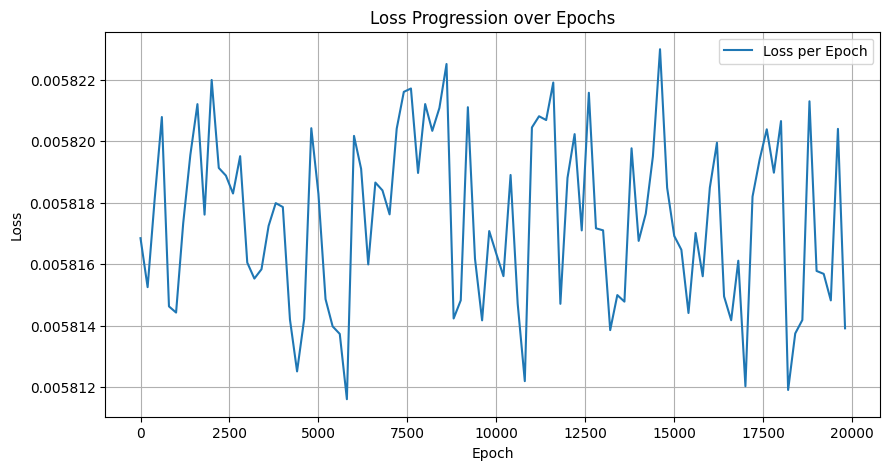

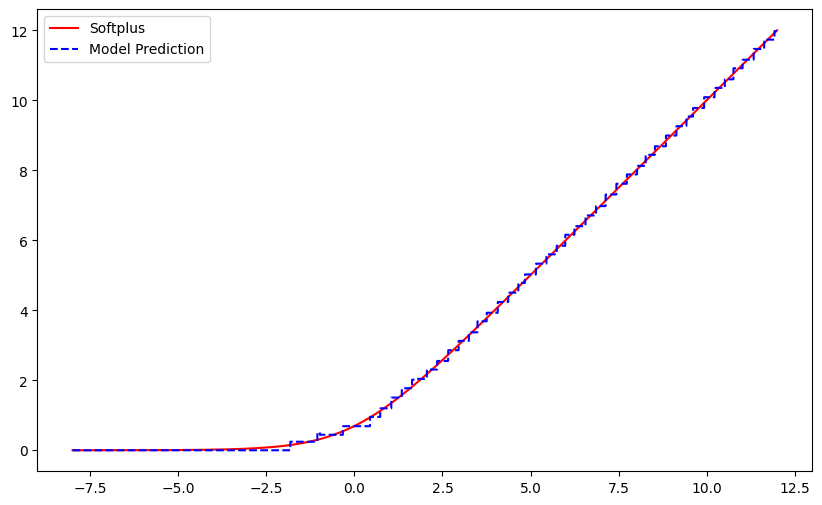

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.0022500313352793455
Epoch 1001/20000, Loss: 0.0022378875873982906
Epoch 2001/20000, Loss: 0.002216723747551441
Epoch 3001/20000, Loss: 0.0022144916001707315
Epoch 4001/20000, Loss: 0.002211559098213911
Epoch 5001/20000, Loss: 0.0022141647059470415
Epoch 6001/20000, Loss: 0.002219836227595806
Epoch 7001/20000, Loss: 0.0022172313183546066
Epoch 8001/20000, Loss: 0.0022156070917844772
Epoch 9001/20000, Loss: 0.0022177211940288544
Epoch 10001/20000, Loss: 0.0022247496526688337
Epoch 11001/20000, Loss: 0.0022259685210883617
Epoch 12001/20000, Loss: 0.0022224688436836004
Epoch 13001/20000, Loss: 0.0022285140585154295
Epoch 14001/20000, Loss: 0.0022234832867980003
Epoch 15001/20000, Loss: 0.0022279303520917892
Epoch 16001/20000, Loss: 0.00222973944619298
Epoch 17001/20000, Loss: 0.0022293035872280598
Epoch 18001/20000, Loss: 0.0022324188612401485
Epoch 19001/20000, Loss: 0.002237152773886919
Loss values: [0.0022500313352793455, 0.0022414522245526314, 0.00224486668594181

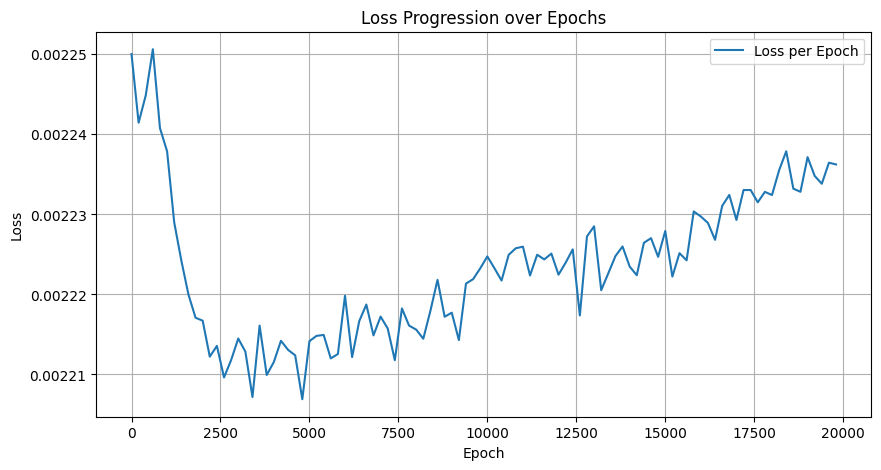

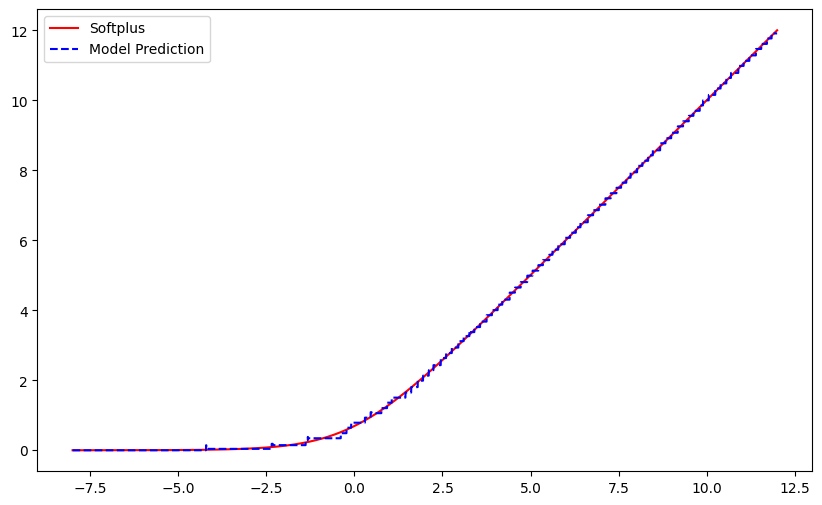

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.0009790444746613503
Epoch 1001/20000, Loss: 0.0010216310620307922
Epoch 2001/20000, Loss: 0.00100066012237221
Epoch 3001/20000, Loss: 0.0008166723418980837
Epoch 4001/20000, Loss: 0.0007243196596391499
Epoch 5001/20000, Loss: 0.0006927127833478153
Epoch 6001/20000, Loss: 0.0007532807649113238
Epoch 7001/20000, Loss: 0.0006738448282703757
Epoch 8001/20000, Loss: 0.0006895349361002445
Epoch 9001/20000, Loss: 0.0007084199460223317
Epoch 10001/20000, Loss: 0.0006582456990145147
Epoch 11001/20000, Loss: 0.0008787268889136612
Epoch 12001/20000, Loss: 0.0008234992856159806
Epoch 13001/20000, Loss: 0.0008296529995277524
Epoch 14001/20000, Loss: 0.0008175858529284596
Epoch 15001/20000, Loss: 0.0007604516576975584
Epoch 16001/20000, Loss: 0.0008004841511137784
Epoch 17001/20000, Loss: 0.0008507728343829513
Epoch 18001/20000, Loss: 0.0008064255234785378
Epoch 19001/20000, Loss: 0.0008040255634114146
Loss values: [0.0009790444746613503, 0.0010408225934952497, 0.0011149989441

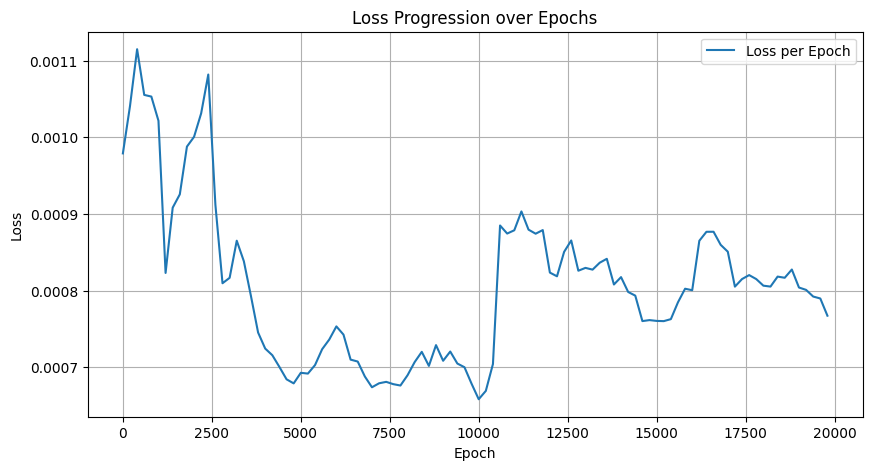

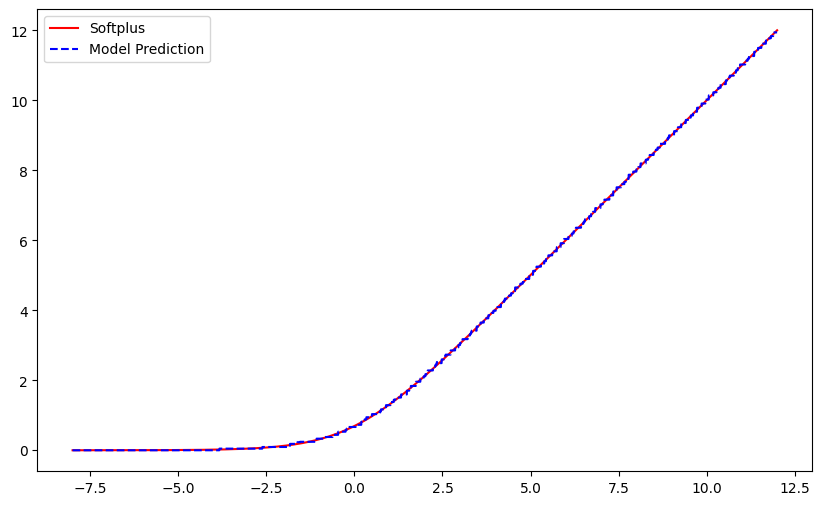

In [7]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()